#First task

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

device(type='cuda')

In [ ]:
!pip install "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.40.2" "trl==0.4.7" wandb

In [ ]:

from datasets import load_dataset, ReadInstruction
from random import randrange

# import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, AutoPeftModelForCausalLM

from trl import SFTTrainer

In [ ]:
dataset_name = 'theblackcat102/evol-codealpaca-v1'
dataset = load_dataset(dataset_name, split=ReadInstruction('train', from_=1000, to=2000, unit='abs'))
# Show dataset size
print(f"dataset size: {len(dataset)}")
# Show an example
print(dataset[randrange(len(dataset))])

dataset size: 1000
{'instruction': 'Revamp the existing code assessment item, ensuring that it handles duplicate values, tuple use cases that involve both even and uneven quantities of components, finding of the median through methods that refrain from list sorting or using built-in functions and establishing a unique comparison function. The function should be called "median".\n\nThe completion of the following code is required:\n\ndef median(l: list, cmp_func: callable):\n    """Return median of elements in the list l without sorting it or using built-in functions.\n    Handles tuples with even and odd number of elements, duplicates, and uses cmp_func for comparisons.\n    """\n#Examples:\n# median([3, 1, 2, 4, 5], lambda a, b: a - b) => 3\n# median([-10, 4, 6, 1000, 10, 20], lambda a, b: a - b) => 15.0\n# median([1, 2, 2, 4, 5], lambda a, b: a - b) => 2', 'output': 'This problem could be solved by ```quickselect``` algorithm which has an average time complexity of O(n) and worst cas

In [ ]:
dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 1000
})

In [ ]:
def format_instruction(sample):
	return f"""### Instruction:
You are a coding assistant that will write a Solution to resolve the following Task:"

### Task:
{sample['instruction']}

### Solution:
{sample['output']}
"""

In [ ]:
print(format_instruction(dataset[randrange(len(dataset))]))

### Instruction:
You are a coding assistant that will write a Solution to resolve the following Task:"

### Task:
Analyze and debug the following piece of code. It is intended to print out a right triangle of size n with particular constraints,
but it is not functioning correctly. The right triangle should be built as follows:
- It should be built with "*".
- Each row should end with a numeric indicator representing the number of "*" on that row.
- It should be padded to the right with "-", for any remaining space up to ‘n’.
Consider n = 5 for output illustration, whilst the code should be able to accept any positive integer as input.

The erroneous code is as follows:
```java
int n = 5;
for (int i = 0; i < n; i++) {
  for (int j = 0; j <= i; j++) {
    System.out.print("*");
  }
  for (int k = 0; k < n - i; k++) {
    System.out.print("-");
  }
  System.out.println(i);
}
```
Debug the code and modify it to meet the above-mentioned requirements.

### Solution:
The erroneous code has tw

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
device_map = {"": 0}

model_name2 = "psmathur/orca_mini_3b"

model2 = AutoModelForCausalLM.from_pretrained(
    model_name2,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map='auto'
    # device_map=device_map
)
model2.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained(model_name2, trust_remote_code=True)
tokenizer2.pad_token = tokenizer2.eos_token
tokenizer2.padding_side = "right"

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config2 = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:

output_dir2 = "/kaggle/working/results2"
per_device_train_batch_size = 1 #4
gradient_accumulation_steps = 1
optim = "paged_adamw_32bit"
save_steps = 100 #0
logging_steps = 10 #25
learning_rate = 7e-05  #4e-3 #2e-4 #1e-5
max_grad_norm = 0.3
max_steps = -1
warmup_ratio = 0.03
lr_scheduler_type = "cosine" #"constant"

training_arguments2 = TrainingArguments(
    output_dir=output_dir2,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length= False, #True,
    lr_scheduler_type=lr_scheduler_type,
    num_train_epochs=1,
)

In [ ]:

max_seq_length = 2048
packing = True #False

trainer2 = SFTTrainer(
    model=model2,
    train_dataset=dataset,
    peft_config=peft_config2,
    # dataset_text_field="instruction",
    packing=packing,
    formatting_func=format_instruction,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer2,
    args=training_arguments2,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [ ]:
for name, module in trainer2.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

The first model was trained on 8k dataset elements, but when internet connection was lost, model was lost too. So it was again trained on 1,37k tasks. Learning on last 370 tasks is shown down and graphic of training first model on 8k data

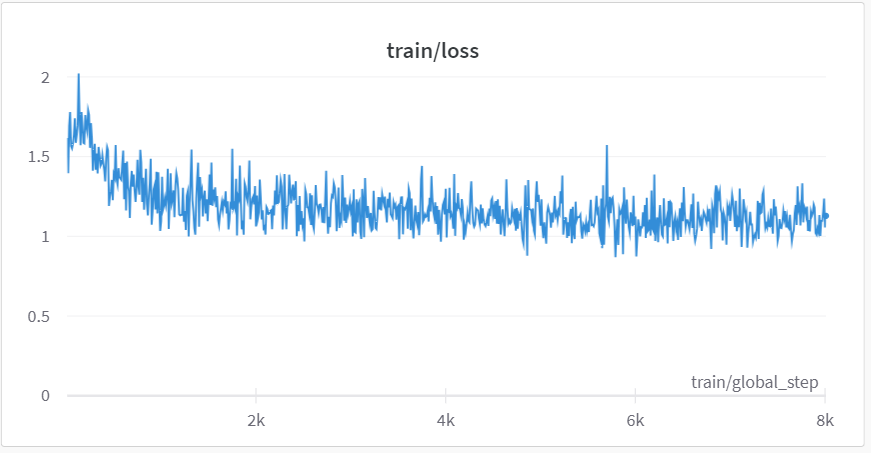

In [ ]:
trainer2.train()

wandb: Currently logged in as: leksa_pramheda (bolgari-projects). Use `wandb login --relogin` to force relogin


Token indices sequence length is longer than the specified maximum sequence length for this model (2757 > 2048). Running this sequence through the model will result in indexing errors
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,1.838800
20,1.731900
30,1.560300
40,1.426500
50,1.447300
60,1.348700
70,1.221100
80,1.313000
90,1.431900
100,1.409000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=371, training_loss=1.2974208403790415, metrics={'train_runtime': 1994.9618, 'train_samples_per_second': 0.501, 'train_steps_per_second': 0.501, 'total_flos': 7907872564838400.0, 'train_loss': 1.2974208403790415, 'epoch': 0.37})

In [ ]:
# save model in local
trainer2.save_model()

In [ ]:
model_to_save2 = trainer2.model.module if hasattr(trainer2.model, 'module') else trainer2.model  # Take care of distributed/parallel training
model_to_save2.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model2 = get_peft_model(model2, lora_config)

There are shown results of training on the different moments of learning. But there no example of result of training 8k model.

##2

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

##1

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
Imagine I've built a complex system on Amazon Redshift, but the anticipated data stream from my Kinesis Data Streams isn't showing up as forecasted, what systematic approach can I employ to identify and correct this anomaly? Furthermore, how can I ensure a smooth data transfer from the Kinesis Data Streams to the sophisticated Redshift environment, considering potential latency issues, data integrity checks, and the improvement of data transfer rates?

### Input:
Diagnosing Anomalies:

1. Verification: First, validate that your Kinesis Data Streams are functioning correctly and the data producers are sending data as expected. AWS provides CloudWatch, a monitoring service that you can use to observe your data streams in real-time.

2. Check the data stream consumer: Ensure that your consumer application(s) or AWS service(s) are 

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
We are running part of our app as a windows service and it needs to b able to access DSNs in order to import through ODBC.  However there seem to be a lot of restrictions found through trial and error on what DSNs it can access.  For example it seems that it cannot 
1. access a system DSN unless the account that is running the service has admin privileges.  (I get an Access Denied error, when trying to connect)
2. access a user DSN that was created by a different user (this one is understandable).
3. access a file DSN across the network

I've read that the purpose of a file DSN is to allow other computers to use it to connect, however i can't seem to make that work.

So does any know, or know where i can find out what all the rules and restrictions on accessing a DSN are when using a windows service. 
thanks

### Input:
There a

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
Create a MongoDB query to search multiple collections.
Collection1: 
books
Collection2:
authors

### Input:
MongoDB does not directly support search within multiple collections within a single query. You might need to perform separate queries to each collection. However, if your data is related (for example, if you have an author's id in your books collection), you can use MongoDB's `$lookup` stage which performs a left outer join to another collection in the same database to filter in documents from the "joined" collection for processing.

Here is a sample query that you can adjust to fit your needs:

```js
db.books.aggregate([
   {
      $lookup:
        {
          from: "authors",
          localField: "author_id",
          foreignField: "_id",
          as: "author_info"
        }
   }
])
```

This operation from the "boo

##3

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
What operations would you need to conduct to find and edit the minimum node of a Fibonacci heap?

### Input:
To find and edit the minimum node of a Fibonacci heap you could use the following steps:

1. Find the minimum node: The smallest node or minimum node in a Fibonacci heap is always kept as the root of the heap. So, finding the minimum node in a Fibonacci heap is a simple task which can be performed in O(1) time complexity. Here is the Python code to perform:

```python
def find_min(self):
    return self.min_node.key
```
   
2. Edit the minimum node: Editing the value of the min_node is straightforward. You just replace the value then perform the necessary adjustments to maintain the properties of the Fibonacci heap. First, replace the value. If the new value is greater than the old one, perform cascading cuts and possibl

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
Develop a Python script that accepts any input text string from a user and applies the following operations:

1. Convert the input text string into its corresponding base64 encoding.
2. Then, take the base64 encoded string and use it as a key to encrypt the original string, using popular encryption algorithms such as AES.
3. Show the cipher text and then decrypt it back to its original form to verify the encryption and decryption processes.

Take note of edge cases like if the user inputs a blank string, numeric values, or special characters. Add error handling mechanisms as well to ensure that the program would not crash due to any unforeseen issues. 

Increase the difficulty further by having the program handle and process multiple strings at once. Upon completion, the program should display each original string, the base64 e

In [ ]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
{sample['instruction']}

### Input:
{sample['output']}

### Response:
"""

input_ids = tokenizer2(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
# outputs = merged_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)
outputs = model2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.5)

print(f"Prompt:\n{prompt}\n")
print(f"\nGenerated instruction:\n{tokenizer2.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"\nGround truth:\n{sample['output']}")

Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that can solve the following Task:

### Task:
What is the computational method to determine the cumulative total of all numerical elements in an array structure, while ignoring non-integer data types and duplicated values?

### Input:
You can do this via multiple programming languages. Here is a Python method:

```python
def sum_uniques(data):
    unique_ints = set()
    for elem in data:
        if isinstance(elem, int):
            unique_ints.add(elem)
    return sum(unique_ints)

# Use it like this:
data = [1, 2, 3, 1, 'a', 3, 4, 5.5]
print(sum_uniques(data))  # Output: 10
```
This function works by first creating a set of unique integers in `data`. It does this by iterating over each element in `data`, checking if it is an instance of int, and if so, adding it to the set. Because sets automatically remove duplicated values, this results in a set of unique integers. Fi

#Second task

In [ ]:
# !wget https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin

--2023-10-25 14:31:25--  https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin
Resolving gpt4all.io (gpt4all.io)... 104.26.0.159, 104.26.1.159, 172.67.71.169, ...
Connecting to gpt4all.io (gpt4all.io)|104.26.0.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3785248281 (3.5G)
Saving to: ‘ggml-gpt4all-j-v1.3-groovy.bin’

ggml-gpt4all-j-v1.3 100%[===================>]   3.52G  45.3MB/s    in 85s     

2023-10-25 14:32:51 (42.3 MB/s) - ‘ggml-gpt4all-j-v1.3-groovy.bin’ saved [3785248281/3785248281]



In [ ]:
!pip install langchain==0.0.139
!pip install chromadb==0.3.23
!pip install pdf2image==1.16.3
!pip install pypdf==3.8.1
# !pip install pygpt4all==1.1.0
!pip install transformers
!pip install protobuf
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.5/530.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.22
    Uninstalling SQLAlchemy-2.0.22:
      Successfully uninstalled SQLAlchemy-2.0.22
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.49 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to buil

In [ ]:
!pip install huggingface-hub==0.16.4

token = #

from huggingface_hub import login
login(token=token, add_to_git_credential=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install langchain --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.0.139
    Uninstalling langchain-0.0.139:
      Successfully uninstalled langchain-0.0.139


In [ ]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import GPT4All
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path

import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
# from langchain.document_loaders import PyPDFDirectoryLoader
# from langchain.loaders import DirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
loader = PyPDFLoader("/content/PK/Theory.pdf")
documents = loader.load_and_split()
len(documents)

# loader = PyPDFDirectoryLoader("/content/PK")
# docs = loader.load_and_split() #.load()
# len(docs)

78

In [ ]:
print(documents[0].page_content)

Theoretical maximum
Information block for work in the 
admissions committee of RTU MIREA 2023
Content
Basic Concepts
General operating rules
Informational resources
Contacts
University sites in Moscow 
University branches
Education at RTU MIREA
College of Programming and Cybersecurity Admission to the College 
of Programming and Cybersecurity Admission calendar to the College 
of Programming and Cybersecurity Admission to the University after 
college
Bachelor's and specialist's degrees Ranking of lists of 
applicants Admission calendar for bachelor's/
specialist's programs Master's programs
Calendar of admission to master's programs 
Postgraduate studies
Calendar of admission to graduate school 
Education system
Special quota
Targeted training
Separate quota
Discounts on training
Olympics
Additional opportunities 
Deferment from the army
Military training center
Dormitory
Admission of foreign citizens Features of 
the 2023 admission campaign Restrictions 
on the submission of document

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64
)
texts = text_splitter.split_documents(documents)
len(texts)

148

In [ ]:
import  sentence_transformers

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
    # sentence-transformers/all-mpnet-base-v2

# embeddings = HuggingFaceInstructEmbeddings(
#     model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
# )

In [ ]:
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
#    temperature=0,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartForCausalLM', 'Prophe

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something incorrectly. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

In [ ]:
%%time
result = qa_chain("What documents are needed for admission to the magistracy?")
print('\n' + 'Time to complete:')

 Based on the information provided, the documents needed for admission to the magistracy are:

1. Passport (identity and citizenship document)
2. Original or copy of a document on previous education (certificate) with an insert containing grades
3. Consent to the processing of personal data (for minors or adults)

Note: The requirements may vary depending on the specific institution and program, so it is always best to check with the admissions office for the most up-to-date and accurate information.

Time to complete:
CPU times: user 8.2 s, sys: 284 ms, total: 8.49 s
Wall time: 10.6 s


In [ ]:
prompt3 = "Show me master's program admission calendar"

In [ ]:
%%time
result3 = qa_chain(prompt3)
print('\n' + 'Time to complete:')

 Based on the provided information, here is the Master's program admission calendar:

* June 20: Start of accepting documents
* July 31: End of acceptance of documents (budget)
* August 5: Publication of competition lists (budget)
* August 7: Last day for accepting original educational documents for participation in the priority stage of enrollment (budget)
* August 8: Publication of lists of those enrolled within quotas (priority stage, budget)
* August 12: Last day for accepting original educational documents for participation in the main stage of enrollment (budget)
* August 14: Publication of lists enrolled at the main stage (budget)
* August 26: End of acceptance of documents (contract)

Please note that this calendar only applies to full-time and part-time courses, and not to bachelor's/specialty programs.

Time to complete:
CPU times: user 15.2 s, sys: 208 ms, total: 15.4 s
Wall time: 21.8 s
